In [1]:
import tensorflow as tf
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import timeit
import pandas as pd

In [2]:
filenames = []
for file in os.listdir('audio'):
    filenames.append(file)
# filenames[0:2]
print("num of files=",len(filenames),",num of actors=",len(filenames)/16)

num of files= 384 ,num of actors= 24.0


In [3]:
random.shuffle(filenames)

In [4]:
# max, min = 76117, 53310
# start, end = 21000/sampling_rate, 47424/sampling_rate
# wave_length = end-start
num_train = int(len(filenames)*0.7)
num_test = len(filenames) - num_train

In [5]:
# for filename in filenames[:num_train]:
#     data, sampling_rate = librosa.load("audio/" + filename, res_type='kaiser_fast', duration=end, offset=start)
#     print(len(data))

In [6]:
# df = pd.DataFrame(columns=['feature'])
# for index, y in enumerate(filenames):
#     data, sampling_rate = librosa.load("audio/" + filename, res_type='kaiser_fast', duration=end, offset=start)
#     mfccs = np.mean(librosa.feature.mfcc(y=data, n_mfcc=25,), axis=0)
#     data_x_train.append(-(mfccs)/100)
    
# df

In [7]:
data_x_train = []
data_x_test = []

start_time = timeit.default_timer()
for filename in filenames[:num_train]:
    data, sampling_rate = librosa.load("audio/" + filename, sr=22050*2, res_type='kaiser_fast', duration=2.5, offset=0.5)
    sampling_rate = np.array(sampling_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13), axis=0)
    data_x_train.append(mfccs)
    
for filename in filenames[num_train:]:
    data, sampling_rate = librosa.load("audio/" + filename, sr=22050*2, res_type='kaiser_fast', duration=2.5, offset=0.5)
    sampling_rate = np.array(sampling_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13), axis=0)
    data_x_test.append(mfccs)
    
stop_time = timeit.default_timer()
print('runtime: ', stop_time - start_time)  

runtime:  53.10320231675781


In [8]:
data_y_train = []
data_y_test = []

for filename in filenames[:num_train]:
    if filename[7] == '3':
        data_y_train.append(1)
    elif filename[7] == '4':
        data_y_train.append(0)
        
for filename in filenames[num_train:]:
    if filename[7] == '3':
        data_y_test.append(1)
    elif filename[7] == '4':
        data_y_test.append(0)   

In [9]:
# takes every value in data_y to an array
# ex: [0, 1, 1, 1, 0] => [[0], [1], [1], [1], [0]]
data_y_train_correct = []
data_y_test_correct = []

for val in data_y_train:
    val_arr = []
    val_arr.append(val)
    data_y_train_correct.append(val_arr)
    
for val in data_y_test:
    val_arr = []
    val_arr.append(val)
    data_y_test_correct.append(val_arr)

In [10]:
data_xy_train = []
for i in range(len(data_x_train)):
    data_xy_train.append( (data_x_train[i], data_y_train_correct[i]) )
    
data_xy_test = []
for i in range(len(data_x_test)):
    data_xy_test.append( (data_x_test[i], data_y_test_correct[i]) )

In [11]:
def getXvalues(data_xy):
    x_values = []
    for data in data_xy:
        x_values.append(data[0])
    return x_values

def getYvalues(data_xy):
    y_values = []
    for data in data_xy:
        y_values.append(data[1])
    return y_values

In [12]:
def logistic_fun(z):
    return 1/(1.0 + np.exp(-z))

In [13]:
data_xy_train[1]

(array([-55.07601615, -53.9678113 , -51.99808471, -52.68013856,
        -51.36067524, -45.86783447, -36.45630698, -32.47057839,
        -31.77282547, -32.56294718, -34.67399085, -33.43064577,
        -29.09111093, -26.89857116, -26.71107754, -28.71720715,
        -30.45515047, -32.71562139, -35.16324702, -35.41624771,
        -37.35934093, -37.7827195 , -36.35807318, -38.03954142,
        -41.45006943, -40.81065937, -39.87549205, -39.98055298,
        -39.40778851, -40.10612067, -39.78948542, -39.82555294,
        -39.31292027, -37.6655235 , -36.88787769, -33.34667676,
        -34.09162509, -34.97651001, -37.72858469, -38.51466028,
        -38.07990811, -36.6012043 , -34.94932801, -31.61729344,
        -30.20094427, -29.08541214, -28.90440469, -28.2859377 ,
        -29.18559165, -31.46124104, -31.01546429, -30.57209871,
        -24.2393767 , -20.95394371, -22.5253479 , -22.88496211,
        -22.69047066, -24.26398895, -26.28268307, -26.38481951,
        -26.83101865, -30.368966  , -31.

In [14]:
features = len(data_xy_train[0][0])
eps = 1e-12

x = tf.placeholder(tf.float32, [None, features])

y_ = tf.placeholder(tf.float32, [None, 1])

W = tf.Variable(tf.zeros([features,1]))

b = tf.Variable(tf.zeros([1]))

y = 1 / (1.0 + tf.exp(-(tf.matmul(x,W) + b)))

loss1 = -(y_ * tf.log(y + eps) + (1 - y_) * tf.log(1 - y + eps))

loss = tf.reduce_mean(loss1)

update = tf.train.GradientDescentOptimizer(0.00001).minimize(loss)

sess = tf.Session()

sess.run(tf.global_variables_initializer())

start_time = timeit.default_timer()

loss_history_train = []
loss_history_test = []

for i in range(0,1000):
    sess.run(update, feed_dict = {x:getXvalues(data_xy_train), y_:getYvalues(data_xy_train)}) #BGD
    loss_history_train.append(np.mean(sess.run(loss1, feed_dict = {x:getXvalues(data_xy_train), y_:getYvalues(data_xy_train)})))
    random.shuffle(data_xy_train)
    
    if i%100 == 0:
        for i in range(len(data_x_test)):
            pred = logistic_fun(np.matmul(getXvalues(data_xy_train)[i],sess.run(W)) + sess.run(b))
            loss_history_test.append(np.mean(sess.run(loss1, feed_dict = {x:getXvalues(data_xy_test), y_:getYvalues(data_xy_test)})))

stop_time = timeit.default_timer()
print('runtime: ', stop_time - start_time)  

runtime:  7.941648237428744


In [15]:
# data_x_train =          [arr1, arr2, arr3]       # data_x_test = [arr4, arr5]
# shuffle(data_x_train) = [arr2, arr3, arr1]
# data_y_train = [0, 1, 1] # data_y_test = [0, 1]

right = 0

for i in range(len(data_x_test)):
    pred = logistic_fun(np.matmul(getXvalues(data_xy_train)[i],sess.run(W)) + sess.run(b))
    if data_y_test[i] == 0 and pred < 0.5:
        right += 1
    if data_y_test[i] == 1 and pred > 0.5:
        right += 1
#     print("pred:",pred,"=",np.round(pred),"true:",data_y_test[i],"right:",right)

In [16]:
#with happy/sad files from first 4 actors we got 6 out of 20 correct, 30%
#with happy/sad files from first 8 actors we got 15 out of 39 correct, 38.46153846153847%
print("right:",right,",total:",num_test,",accuracy:",right/num_test)

right: 58 ,total: 116 ,accuracy: 0.5


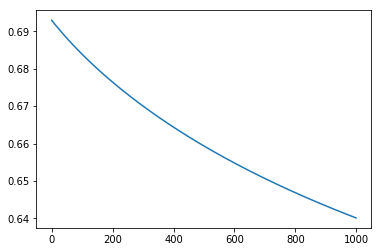

In [19]:
plt.plot(loss_history_train)


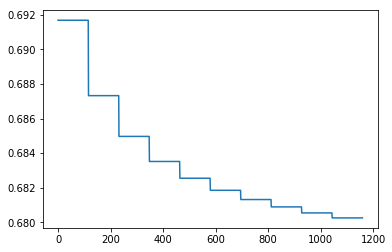

In [20]:
plt.plot(loss_history_test)